In [1]:
import pandas as pd
import numpy as np
import sklearn

In [14]:
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
X = pd.read_excel("X.xlsx")
y = pd.read_excel("y.xlsx")

In [4]:
X = X.drop(columns=['Unnamed: 0'])
y = y.drop(columns=['Unnamed: 0'])

In [5]:
numerical = ['age',
       'games_played', 'minutes_played', 
       'player_efficiency_rating', 'true_shooting_percentage',
       'three_point_attempt_rate', 'free_throw_attempt_rate',
       'offensive_rebound_percentage', 'defensive_rebound_percentage',
       'assist_percentage', 'steal_percentage',
       'block_percentage', 'turnover_percentage', 'usage_percentage',
       'offensive_win_shares', 'defensive_win_shares',
       'win_shares_per_48_minutes', 'offensive_box_plus_minus',
       'defensive_box_plus_minus',
       'value_over_replacement_player','O-LEBRON', 'D-LEBRON', 'Wins Added', 'ORPM', 'DRPM', 'poss',
       'raptor_offense', 'raptor_defense', 'war_total', 'war_reg_season',
       'war_playoffs', 'predator_offense', 'predator_defense', 'pace_impact',
       'LA_RAPM__Def', 'LA_RAPM__Off', 'RA_EFG__Def', 'RA_EFG__Off',
       'RA_FTR__Def', 'RA_FTR__Off', 'RA_ORBD__Def', 'RA_ORBD__Off',
       'RA_TOV__Def', 'RA_TOV__Off', 'RAPM__Def', 'RAPM__Off']

categorical = ["Type"]

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.13, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13, random_state=42)

# scale the numerical features only (this leaves out the dummy features from earlier)
from sklearn.preprocessing import StandardScaler
features = numerical
scaler = StandardScaler()

X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])
X_val[features] = scaler.transform(X_val[features])

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression
select = SelectKBest(f_regression, k=20)

best_features = select.fit_transform(X_train, y_train)
feature_scores = pd.concat([pd.Series(X_train.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]

In [8]:
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(15)['features'])

In [9]:
X_train = X_train[features]
X_test = X_test[features]
X_val = X_val[features]

In [10]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))
    print("mse-log: ", mean_squared_log_error(y_test, y_pred))

In [11]:
def run(model, model_name, x_train, x_val):
    """ Fits the model and prints out results from calling evaluate on the training and validation set
        parameters:
            model
                the unfitted model, from sklearn (has to have a fit and predict method)
            model_name
                String, the name of the model
            x_train
                DataFrame, the training set
            x_val
                DataFrame, the validation set
                
        returns:
            nothing
        
    """
    model = model.fit(x_train, y_train)
    y_pred = np.clip(model.predict(x_train), 0, 1000) # since negative results are meaningless
    
    print("[{0}] These are the results for the training set.".format(model_name))
    
    evaluate(y_pred, y_train)
    print("--------------------------------------")
    
    print("[{0}] These are the results for the validation set.".format(model_name))
    y_pred = np.clip(model.predict(x_val), 0, 1000) # since negative results are meaningless
    
    evaluate(y_pred, y_val)
    
    print("_____________________________________________")

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import *

In [317]:
params = {'n_estimators': 600,
 'min_samples_split': 8,
 'min_samples_leaf': 9,
 'max_features': 'log2',
 'max_depth': 2,
 'learning_rate': 0.05,
 'alpha': 0.55,
  'subsample': 0.75,
 'loss': 'quantile'}
model_gbr = GradientBoostingRegressor(**params)
model_gbr.fit(X_train[features], y_train)

GradientBoostingRegressor(alpha=0.55, learning_rate=0.05, loss='huber',
                          max_depth=2, max_features='log2', min_samples_leaf=9,
                          min_samples_split=8, n_estimators=600,
                          subsample=0.75)

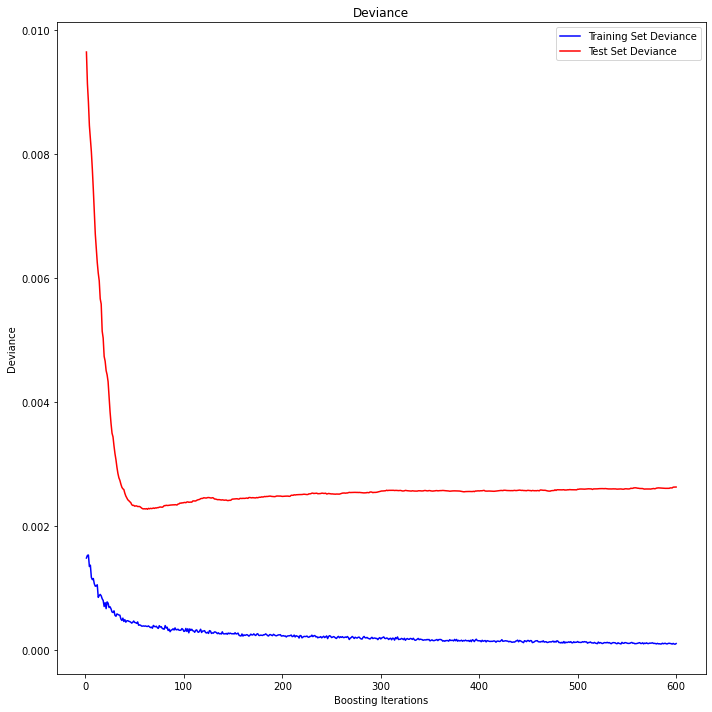

In [318]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(model_gbr.staged_predict(X_val[features])):
    test_score[i] = mean_squared_error(y_val, y_pred)

fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, model_gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [275]:
from sklearn.model_selection import *
# Number of boosting iterations
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 25)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(1, 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3, 5, 7, 9]
alphas = [x for x in np.arange(0.05, 0.85, 0.05)]
learning_rates = [x for x in np.arange(0.05, 0.001, -0.01)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'learning_rate': learning_rates,
               'alpha': alphas}

In [188]:
rf_random = RandomizedSearchCV(estimator = GradientBoostingRegressor(loss='quantile'), param_distributions = random_grid, n_iter = 250, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed: 15.6min finished


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(loss='quantile'),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'alpha': [0.05, 0.1,
                                                  0.15000000000000002, 0.2,
                                                  0.25, 0.3,
                                                  0.35000000000000003, 0.4,
                                                  0.45, 0.5, 0.55,
                                                  0.6000000000000001,
                                                  0.6500000000000001,
                                                  0.7000000000000001,
                                                  0.7500000000000001, 0.8],
                                        'learning_rate': [0.05, 0.04, 0.03,
                                                          0.019999999999999997,
                                                          0.009999999999999995],
               

In [319]:
run(model_gbr, "Gradient Boost Decision Tree", X_train, X_val)

[Gradient Boost Decision Tree] These are the results for the training set.
r^2:  0.8448572629251406
mse:  0.0010017020435904005
variance_score:  0.8514425249197921
mse-log:  0.0007885424378499227
--------------------------------------
[Gradient Boost Decision Tree] These are the results for the validation set.
r^2:  0.6923994736085777
mse:  0.0023840268487250868
variance_score:  0.6928952285833152
mse-log:  0.0019702881744336435
_____________________________________________


In [320]:
evaluate(model_gbr.predict(X_test), y_test)

r^2:  0.5855440060247474
mse:  0.0019651389266119096
variance_score:  0.5855623183731034
mse-log:  0.0015753961775554944
